In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os, sys
import re
import json
import glob 
import datetime
from collections import Counter

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from wordcloud import WordCloud

In [81]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath(r'C:\Users\Eshetu\Desktop\10Academy\week0_starter_network_analysis')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils

In [73]:
# combine all json file in all-weeks8-9
def slack_parser(path_channel):
    """ parse slack data to extract useful informations from the json file
        step of execution
        1. Import the required modules
        2. read all json file from the provided path
        3. combine all json files in the provided path
        4. extract all required informations from the slack data
        5. convert to dataframe and merge all
        6. reset the index and return dataframe
    """

    combined = []
    for json_file in glob.glob(f"{path_channel}*.json"):
        with open(json_file, 'r', encoding="utf8") as slack_data:
            data = json.load(slack_data)
            combined.append(data)

        # loop through all json files and extract required informations
    dflist = []
    for slack_data in combined:
        msg_type, msg_content, sender_id, time_msg, msg_dist, time_thread_st, reply_users, \
        reply_count, reply_users_count, tm_thread_end = [],[],[],[],[],[],[],[],[],[]
        for row in slack_data:
            if 'bot_id' in row.keys():
                continue
            else:
                msg_type.append(row['type'])
                msg_content.append(row['text'])
                if 'user_profile' in row.keys(): sender_id.append(row['user_profile']['real_name'])
                else: sender_id.append('Not provided')
                time_msg.append(row['ts'])
                if 'blocks' in row.keys() and row['blocks'] is not None and len(row['blocks']) > 0 \
                                          and 'elements' in row['blocks'][0].keys() and row['blocks'][0]['elements'] is not None \
                                          and len(row['blocks'][0]['elements']) > 0 and 'elements' in row['blocks'][0]['elements'][0].keys() \
                                          and row['blocks'][0]['elements'][0]['elements'] is not None \
                                          and len(row['blocks'][0]['elements'][0]['elements']) > 0:
                    msg_dist.append(row['blocks'][0]['elements'][0]['elements'][0]['type'])
                else: msg_dist.append('reshared')
                if 'thread_ts' in row.keys():
                    time_thread_st.append(row['thread_ts'])
                else:
                    time_thread_st.append(0)
                if 'reply_users' in row.keys(): reply_users.append(",".join(row['reply_users'])) 
                else:    reply_users.append(0)
                if 'reply_count' in row.keys():
                    reply_count.append(row['reply_count'])
                    reply_users_count.append(row['reply_users_count'])
                    tm_thread_end.append(row['latest_reply'])
                else:
                    reply_count.append(0)
                    reply_users_count.append(0)
                    tm_thread_end.append(0)
        data = zip(msg_type, msg_content, sender_id, time_msg, msg_dist, time_thread_st,
         reply_count, reply_users_count, reply_users, tm_thread_end)
        columns = ['msg_type', 'msg_content', 'sender_name', 'msg_sent_time', 'msg_dist_type',
         'time_thread_start', 'reply_count', 'reply_users_count', 'reply_users', 'tm_thread_end']

        df = pd.DataFrame(data=data, columns=columns)
        df = df[df['sender_name'] != 'Not provided']
        dflist.append(df)
    dfall = pd.concat(dflist, ignore_index=True)
    dfall['channel'] = path_channel.split('/')[-2].split('.')[0]    
    dfall = dfall.reset_index(drop=True)
    return dfall

In [24]:
def parse_slack_reaction(path, channel):
    """get reactions"""
    dfall_reaction = pd.DataFrame()
    combined = []
    for json_file in glob.glob(f"{path}*.json"):
        with open(json_file, 'r') as slack_data:
            combined.append(slack_data)

    reaction_name, reaction_count, reaction_users, msg, user_id = [], [], [], [], []

    for k in combined:
        slack_data = json.load(open(k.name, 'r', encoding="utf-8"))
        
        for i_count, i in enumerate(slack_data):
            if 'reactions' in i.keys():
                for j in range(len(i['reactions'])):
                    msg.append(i['text'])
                    user_id.append(i['user'])
                    reaction_name.append(i['reactions'][j]['name'])
                    reaction_count.append(i['reactions'][j]['count'])
                    reaction_users.append(",".join(i['reactions'][j]['users']))
                
    data_reaction = zip(reaction_name, reaction_count, reaction_users, msg, user_id)
    columns_reaction = ['reaction_name', 'reaction_count', 'reaction_users_count', 'message', 'user_id']
    df_reaction = pd.DataFrame(data=data_reaction, columns=columns_reaction)
    df_reaction['channel'] = channel
    return df_reaction

In [29]:
def get_community_participation(path):
    """ specify path to get json files"""
    combined = []
    comm_dict = {}
    for json_file in glob.glob(f"{path}*.json"):
        with open(json_file, 'r') as slack_data:
            combined.append(slack_data)
    # print(f"Total json files is {len(combined)}")
    for i in combined:
        a = json.load(open(i.name, 'r', encoding='utf-8'))

        for msg in a:
            if 'replies' in msg.keys():
                for i in msg['replies']:
                    comm_dict[i['user']] = comm_dict.get(i['user'], 0)+1
    return comm_dict

In [43]:
def convert_2_timestamp(column, data):
    """convert from unix time to readable timestamp
        args: column: columns that needs to be converted to timestamp
                data: data that has the specified column
    """
    if column in data.columns.values:
        timestamp_ = []
        for time_unix in data[column]:
            if time_unix == 0:
                timestamp_.append(0)
            else:
                a = datetime.datetime.fromtimestamp(float(time_unix))
                timestamp_.append(a.strftime('%Y-%m-%d %H:%M:%S'))
        return timestamp_
    else: 
        print(f"{column} not in data")

In [48]:
def get_tagged_users(df):
    """get all @ in the messages"""

    return df['msg_content'].map(lambda x: re.findall(r'@U\w+', x))

In [69]:
def map_userid_2_realname(user_profile: dict, comm_dict: dict, plot=False):
    """
    map slack_id to realnames
    user_profile: a dictionary that contains users info such as real_names
    comm_dict: a dictionary that contains slack_id and total_message sent by that slack_id
    """
    user_dict = {} # to store the id
    real_name = [] # to store the real name
    ac_comm_dict = {} # to store the mapping
    count = 0
    # collect all the real names
    for i in range(len(user_profile['profile'])):
        real_name.append(dict(user_profile['profile'])[i]['real_name'])

    # loop the slack ids
    for i in user_profile['id']:
        user_dict[i] = real_name[count]
        count += 1

    # to store mapping
    for i in comm_dict:
        if i in user_dict:
            ac_comm_dict[user_dict[i]] = comm_dict[i]

    ac_comm_dict = pd.DataFrame(data= zip(ac_comm_dict.keys(), ac_comm_dict.values()),
    columns=['LearnerName', '# of Msg sent in Threads']).sort_values(by='# of Msg sent in Threads', ascending=False)
    
    if plot:
        ac_comm_dict.plot.bar(figsize=(15, 7.5), x='LearnerName', y='# of Msg sent in Threads')
        plt.title('Student based on Message sent in thread', size=20)
        
    return ac_comm_dict

In [97]:
def get_top_20_user(data, channel):
    """get user with the highest number of message sent to any channel"""

    data['sender_name'].value_counts()[:20].plot.bar(figsize=(15, 7.5))
    plt.title(f'Top 20 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

    data['sender_name'].value_counts()[-10:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom 10 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

def draw_avg_reply_count(data, channel='Random'):
    """who commands many reply?"""

    data.groupby('sender_name')['reply_count'].mean().sort_values(ascending=False)[:20]\
        .plot(kind='bar', figsize=(15,7.5));
    plt.title(f'Average Number of reply count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_avg_reply_users_count(data, channel='Random'):
    """who commands many user reply?"""

    data.groupby('sender_name')['reply_users_count'].sum().sort_values(ascending=False)[:20].plot(kind='bar',
     figsize=(15,7.5));
    plt.title(f'Average Number of reply user count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_wordcloud(msg_content, week):
    # word cloud visualization
    allWords = ' '.join([twts for twts in msg_content])
    wordCloud = WordCloud(background_color='#975429', width=500, height=300, random_state=21, max_words=500, mode='RGBA',
                            max_font_size=140, stopwords=stopwords.words('english')).generate(allWords)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout()
    plt.title(f'WordCloud for {week}', size=30)
    plt.show()

def draw_user_reaction(data, channel):
    data.groupby('sender_name')[['reply_count', 'reply_users_count']].sum()\
        .sort_values(by='reply_count',ascending=False)[:10].plot(kind='bar', figsize=(15, 7.5))
    plt.title(f'User with the most reaction in #{channel}', size=25);
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()
    
def plot_common_words(json_file_path, channel_name):
    # Read the JSON file
    with open(json_file_path, 'r', encoding="utf8") as json_file:
        data = json.load(json_file)

    # Convert the data to a DataFrame (adjust as per your JSON structure)
    df = pd.DataFrame(data)

    # Filter messages for the specified channel
    channel_data = df[df['channel'] == channel_name]

    # Combine the text of messages in the channel
    all_text = ' '.join([str(msg.get('text', '')) for msg in channel_data['topic']])

    # Split the text into words
    words = all_text.split()

    # Create a pandas Series for easy word counting
    word_counts = pd.Series(words).value_counts()

    # Plot the top N words
    top_n = 20  # Change this value to adjust the number of words to display
    plt.figure(figsize=(12, 6))
    word_counts.head(top_n).plot(kind='bar', color='skyblue')
    plt.title(f'Top {top_n} Words in #{channel_name}')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [88]:
pfill = slack_parser(r'C:/Users/Eshetu/Desktop/10Academy/all-week/')
pfill.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2855 entries, 0 to 2854
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   msg_type           2855 non-null   object
 1   msg_content        2855 non-null   object
 2   sender_name        2855 non-null   object
 3   msg_sent_time      2855 non-null   object
 4   msg_dist_type      2855 non-null   object
 5   time_thread_start  2855 non-null   object
 6   reply_count        2855 non-null   int64 
 7   reply_users_count  2855 non-null   int64 
 8   reply_users        2855 non-null   object
 9   tm_thread_end      2855 non-null   object
 10  channel            2855 non-null   object
dtypes: int64(2), object(9)
memory usage: 245.5+ KB


In [99]:
# Q1. which user has the highest number of reply counts?
user_with_highest_replies = pfill.groupby('sender_name')['reply_count'].sum().idxmax()
print(f"The user with the highest number of reply counts is: {user_with_highest_replies}")


The user with the highest number of reply counts is: Cristian Wilson


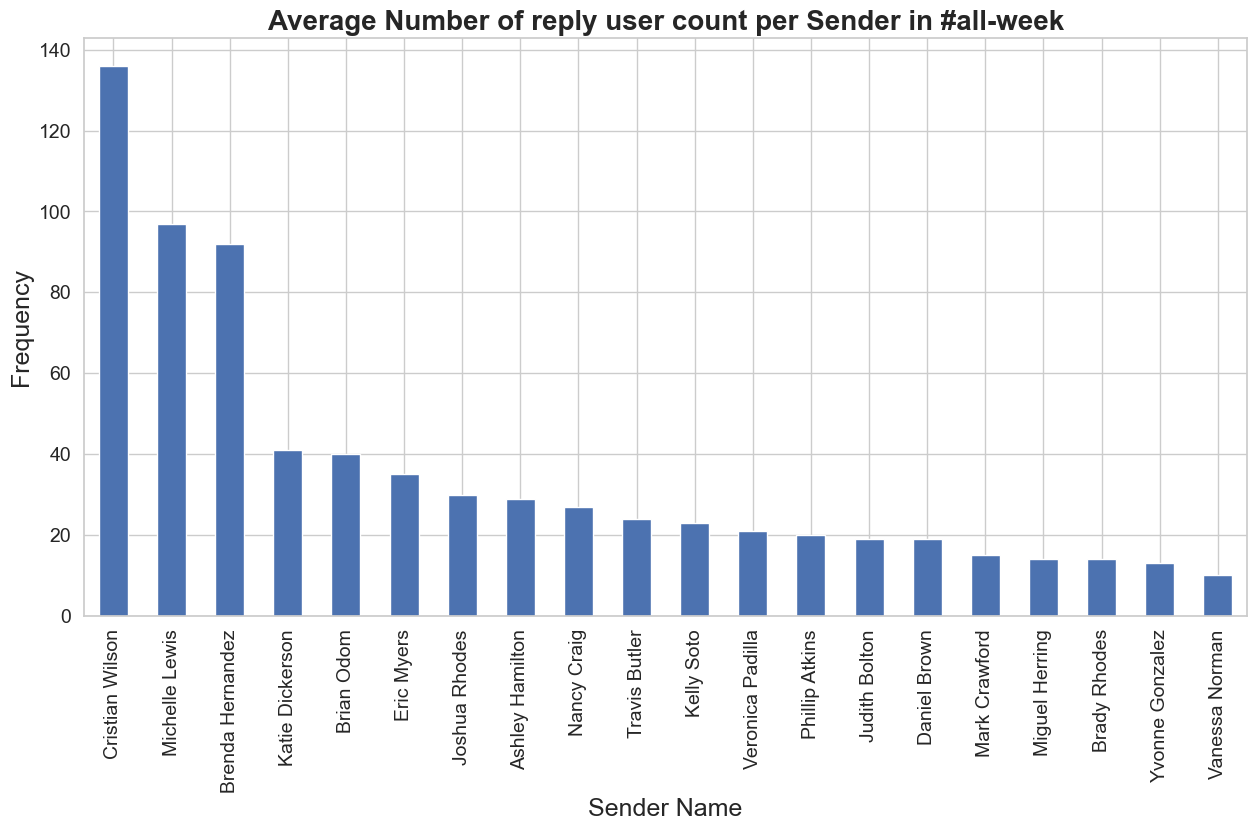

In [122]:
# Q2. which user has the highest number of reply counts?
draw_avg_reply_users_count(pfill,'all-week')

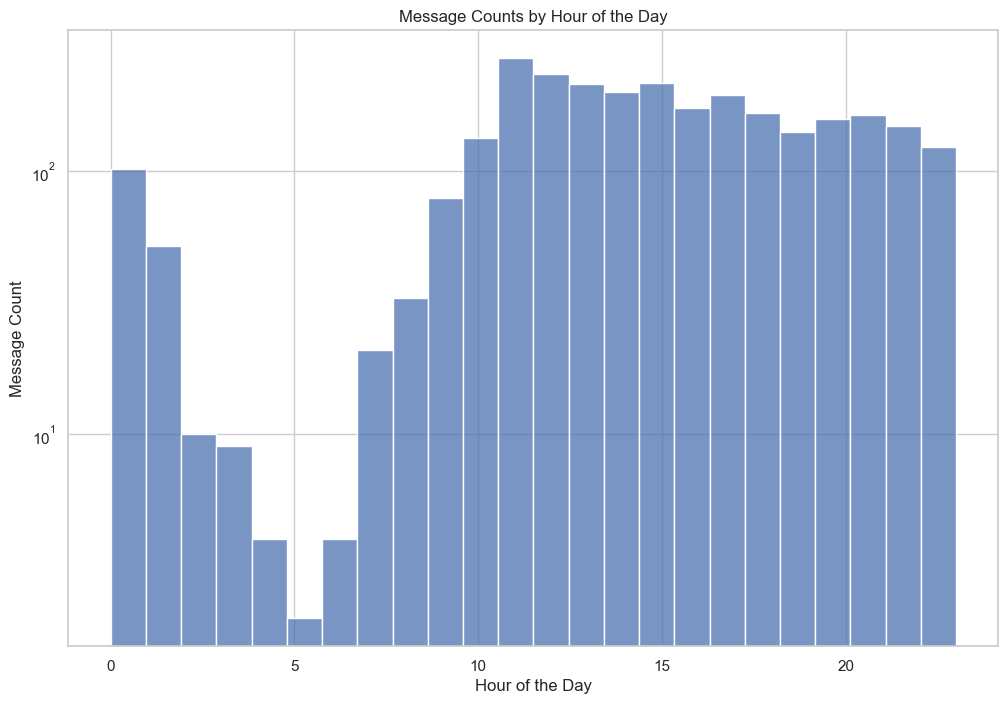

In [100]:
# Q3. what is the time range of the day that most messages are sent?
# Extract the timestamp and hour from the msg_sent_time
pfill['msg_sent_timestamp'] = utils.convert_2_timestamp('msg_sent_time', pfill)
pfill['hour'] = pd.to_datetime(pfill['msg_sent_timestamp']).dt.hour

# Plot the histogram
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.histplot(pfill['hour'], bins=24, kde=False)
plt.yscale('log')
plt.title('Message Counts by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Message Count')

plt.show()


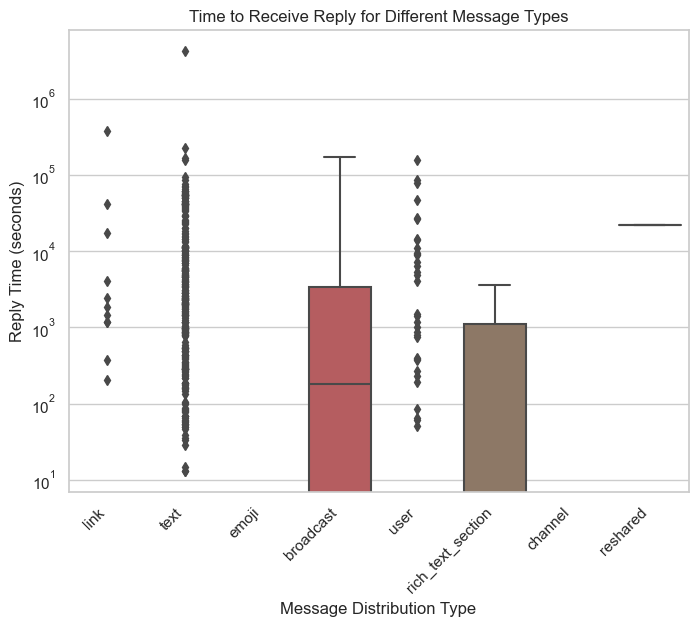

In [103]:
# Q4. what kind of messages are replied faster than others?
# Convert msg_sent_time and tm_thread_end to timestamps
pfill['msg_sent_timestamp'] = utils.convert_2_timestamp('msg_sent_time', pfill)
pfill['tm_thread_end_timestamp'] = utils.convert_2_timestamp('tm_thread_end', pfill)

# Calculate the time it takes to receive a reply
pfill['reply_time'] = (pd.to_datetime(pfill['tm_thread_end_timestamp']) - pd.to_datetime(pfill['msg_sent_timestamp'])).dt.total_seconds()

# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.boxplot(x='msg_dist_type', y='reply_time', data=pfill)
plt.yscale('log')
plt.title('Time to Receive Reply for Different Message Types')
plt.xlabel('Message Distribution Type')
plt.ylabel('Reply Time (seconds)')
plt.xticks(rotation=45, ha='right')

plt.show()


#This code calculates the time it takes to receive a reply for different message types and visualizes it using a boxplot. 
#The x-axis represents the message distribution type, the y-axis represents the log-scaled reply time in seconds, and 
#each boxplot shows the distribution of reply times for a specific message distribution type.



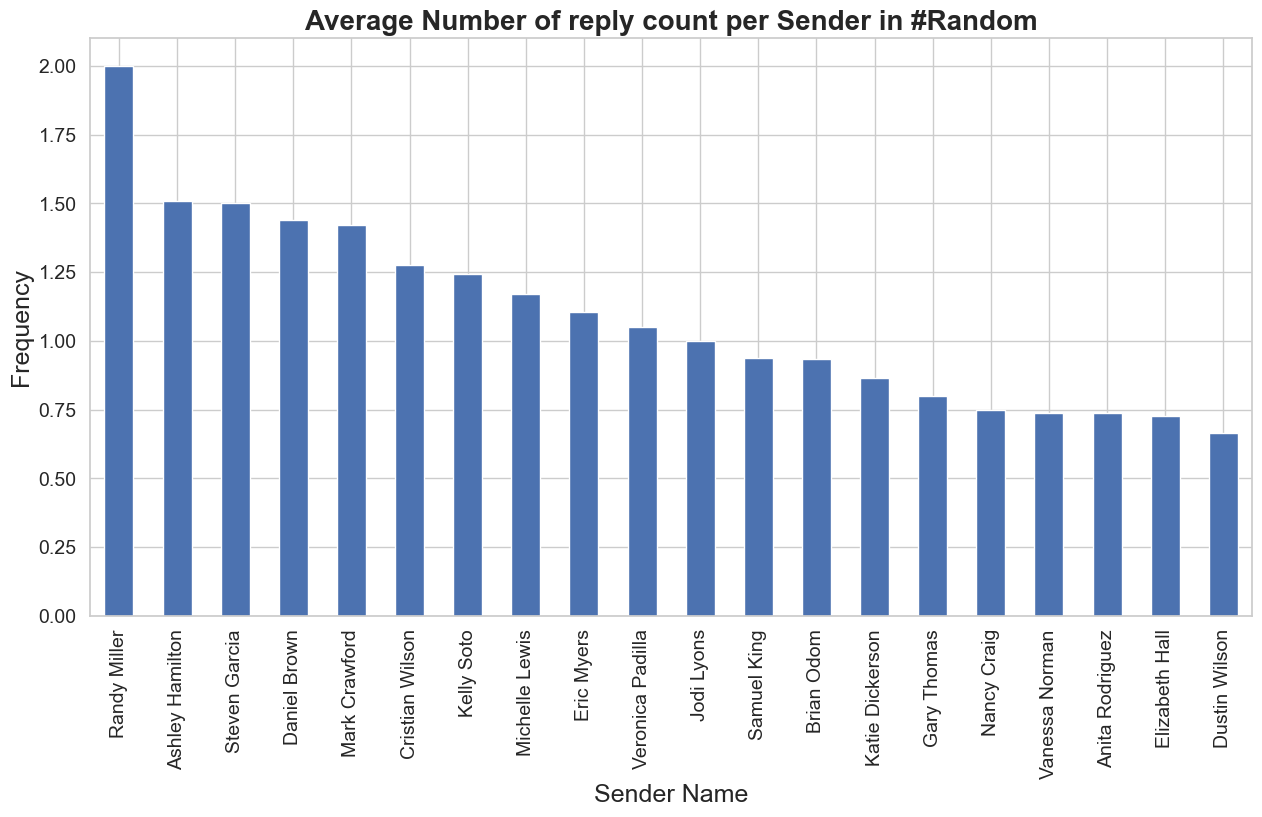

In [119]:
# Draw a bar plot for the average reply count per sender in the 'Random' channel
draw_avg_reply_count(pfill, channel='Random')


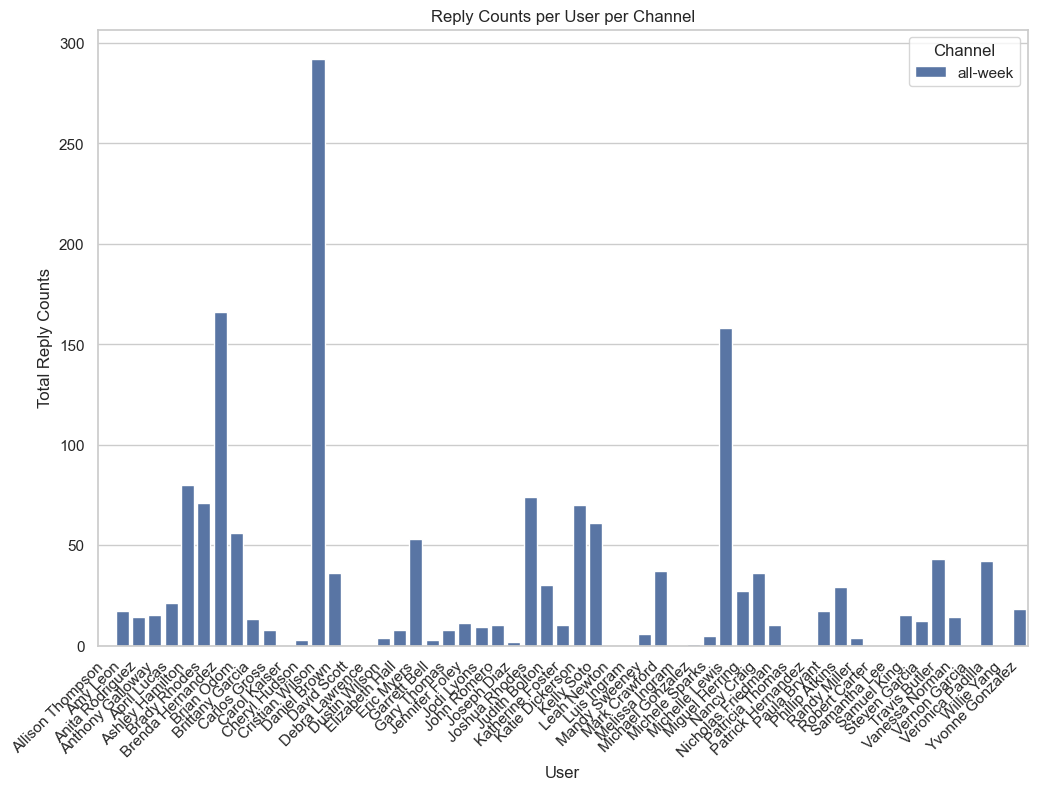

In [147]:
# Q5. Relationship between # of messages and # of reactions
# Visualize the relationship between # of messages and # of reactions
# Group by user and channel, and sum the reply counts
grouped_data = pfill.groupby(['sender_name', 'channel'])['reply_count'].sum().reset_index()

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='sender_name', y='reply_count', hue='channel', data=grouped_data)
plt.title('Reply Counts per User per Channel')
plt.xlabel('User')
plt.ylabel('Total Reply Counts')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Channel', loc='upper right')
plt.show()


category
Other       2702
Question     142
Answer        11
Name: count, dtype: int64


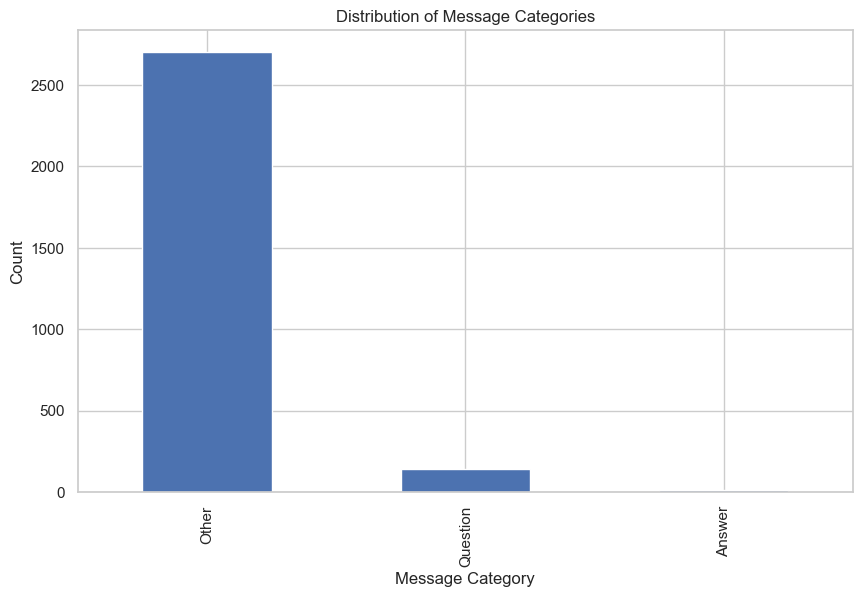

In [115]:
# Q6. Classify messages into different categories such as questions, answers, comments, etc.
# Get tagged users in the messages
pfill['tagged_users'] = get_tagged_users(pfill)

# Create new columns for message categories
pfill['category'] = 'Other'  # Default category

# Identify and classify messages based on certain keywords or patterns
pfill.loc[pfill['msg_content'].str.contains('(?:^|\W)\\?+'), 'category'] = 'Question'
pfill.loc[pfill['msg_content'].str.contains('(?:^|\W)answer(?:$|\W)', case=False), 'category'] = 'Answer'
pfill.loc[pfill['msg_content'].str.contains('(?:^|\W)comment(?:$|\W)', case=False), 'category'] = 'Comment'

# Display the distribution of message categories
category_counts = pfill['category'].value_counts()
print(category_counts)

# Plot the distribution
category_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Distribution of Message Categories')
plt.xlabel('Message Category')
plt.ylabel('Count')
plt.show()


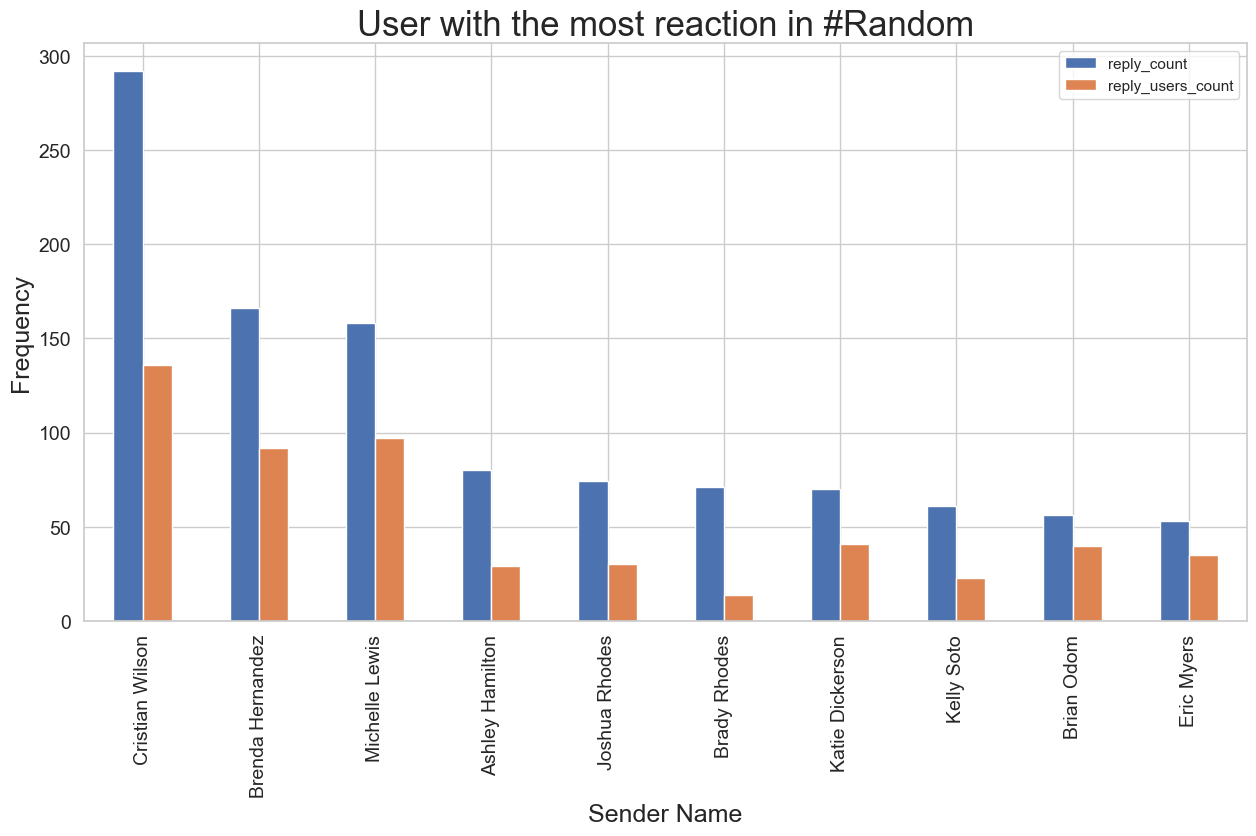

In [118]:
# Which users got the most reactions?
draw_user_reaction(pfill, channel='Random')


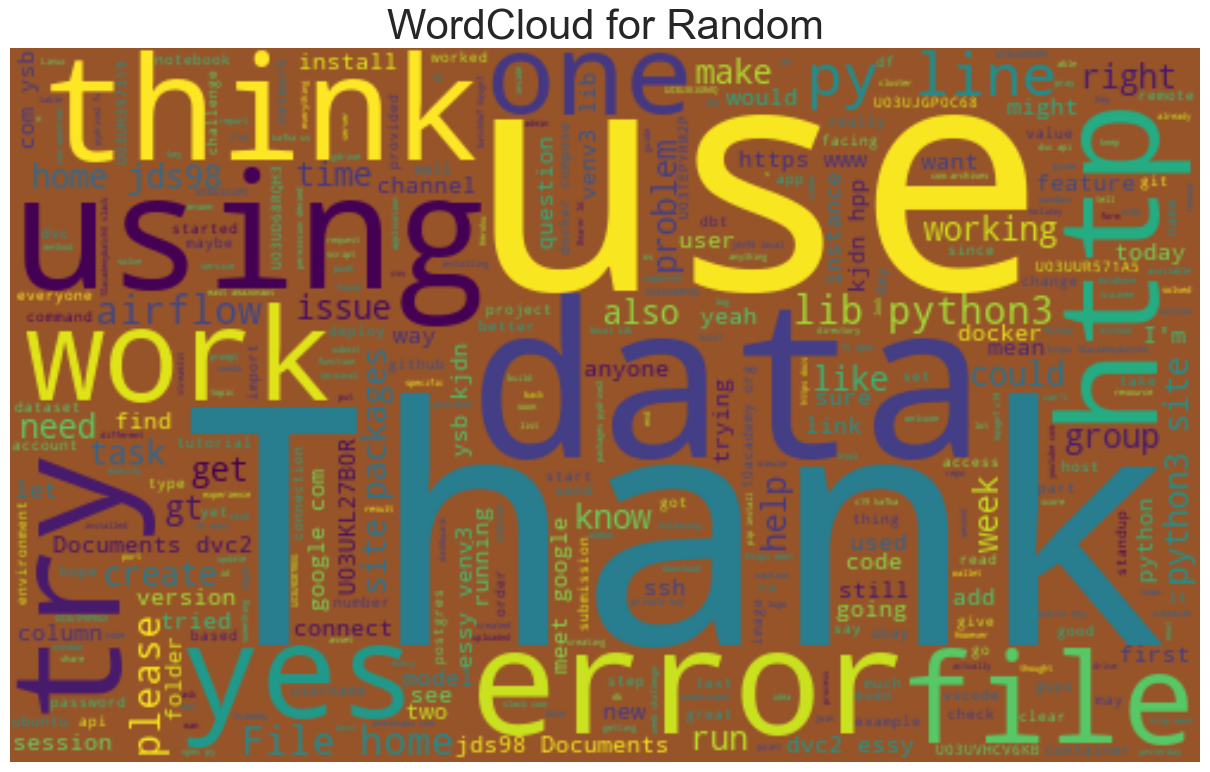

In [124]:
# Draw a word cloud for topics in the 'Random' channel
# Model topics mentioned in the channel
draw_wordcloud(pfill['msg_content'], week='Random')


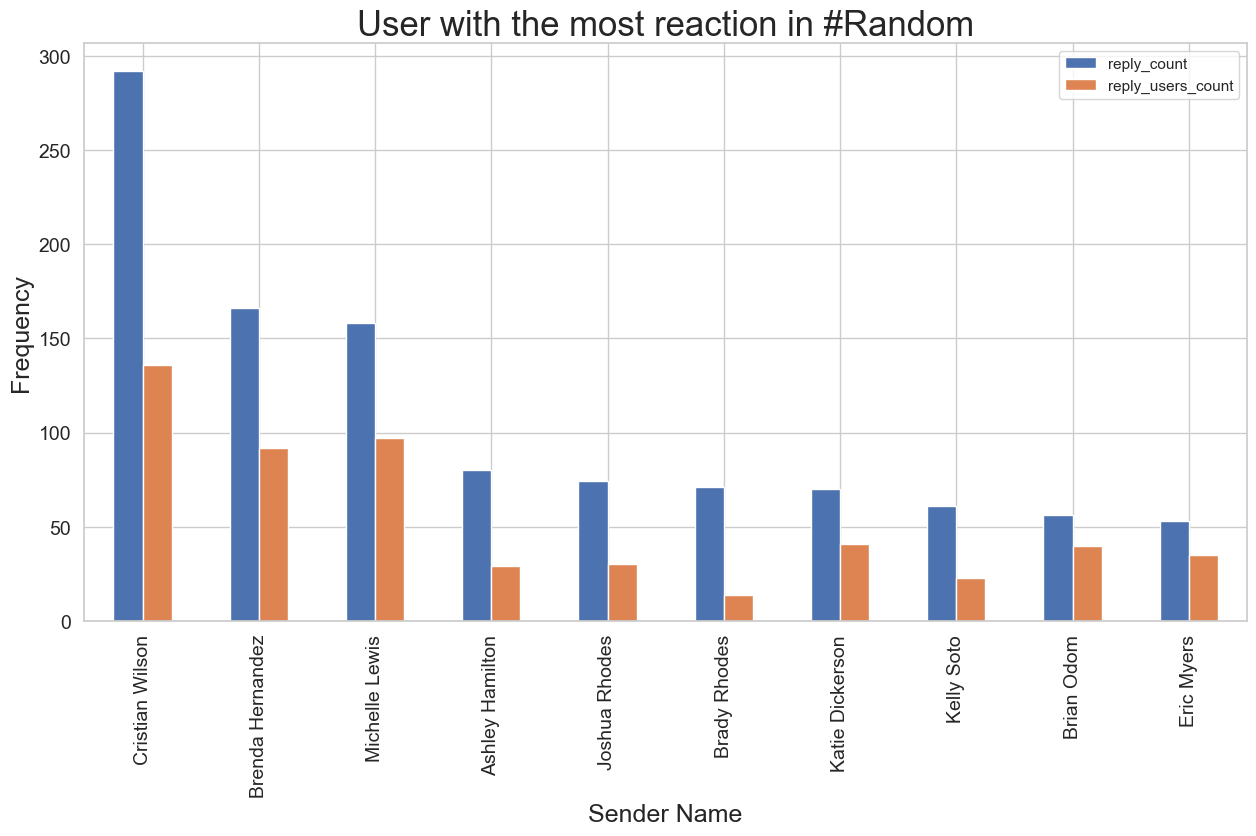

In [125]:
# Draw a bar plot for users with the most reactions in the 'Random' channel
draw_user_reaction(pfill, channel='Random')


In [137]:
# What are the topics that got the most reactions?

# Parse Slack reactions for the 'all-week' channel
reaction_data = parse_slack_reaction(r'C:/Users/Eshetu/Desktop/10Academy/all-week/', 'all-week')

# Get the topics with the most reactions
top_reacted_topics = reaction_data.groupby('message')['reaction_count'].sum().sort_values(ascending=False)

# Display the top topics with the most reactions
print(top_reacted_topics.head(10))


message
Good morning winners, welcome to week 9 of week 12 of this intensive training. We commend your resilience and perseverance as you sail through the thick and thin of this training. You’ve been pushing since the day you applied for this training and you never cease to push to get your tasks done. We are proud of you! You’ve started seeing some rays of light inside the tunnel - in the coming weeks, you’ll eventually see the light at the end of the tunnel. Do have a great week ahead :blush:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [126]:
# Get community participation for the 'all-week' channel
community_participation = get_community_participation(r'C:/Users/Eshetu/Desktop/10Academy/all-week/')

# Convert the dictionary to a DataFrame for better visualization
community_participation_df = pd.DataFrame(list(community_participation.items()), columns=['User ID', 'Message Count'])

# Sort the DataFrame by message count in descending order
community_participation_df = community_participation_df.sort_values(by='Message Count', ascending=False)

# Display the DataFrame
print(community_participation_df)


        User ID  Message Count
7   U03UH397319            220
14  U03UVHCV6KB            210
10  U03UUR571A5            203
26  U03V6HMRPGQ            162
13  U03UJGP0C68            141
9   U03UD68RQH3            122
4   U03U1FNPEUX             97
23  U03UG32J3PC             87
27  U03UKL27B0R             85
21  U03UJN29Y4C             81
30  U03UG4Q7V42             77
1   U03UJGRN5E0             58
25  U03UG1Z21JP             54
16  U03TEPYRM2P             47
34  U03UJKJGRAQ             46
47  U03UJH1EQQL             39
39  U03U9DB7REG             38
11  U03V785NLSU             34
41  U03UFV7HFNF             33
20  U03U9EJR362             32
24  U03UUMM7Y8H             30
33  U03UHB8CXDY             30
43  U03V61VGQG0             29
3   U03U93GNNVB             28
5   U03UG5VFN03             26
52  U03UUN8M4RX             22
50  U03U1HAG9TR             19
38  U03UUP56MDF             18
22  U03V8LHPDME             17
17  U03U9FWPNCE             13
19  U03UP7V9Q57             12
6   U03U

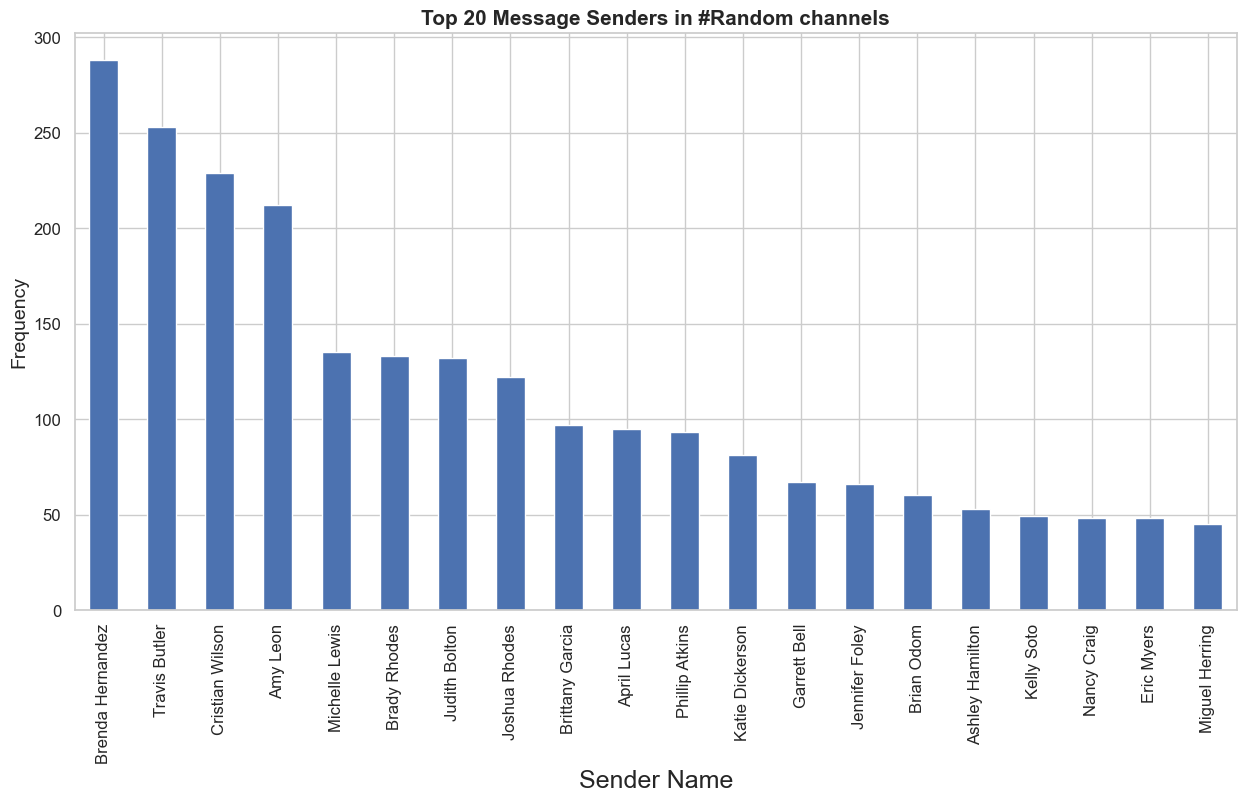

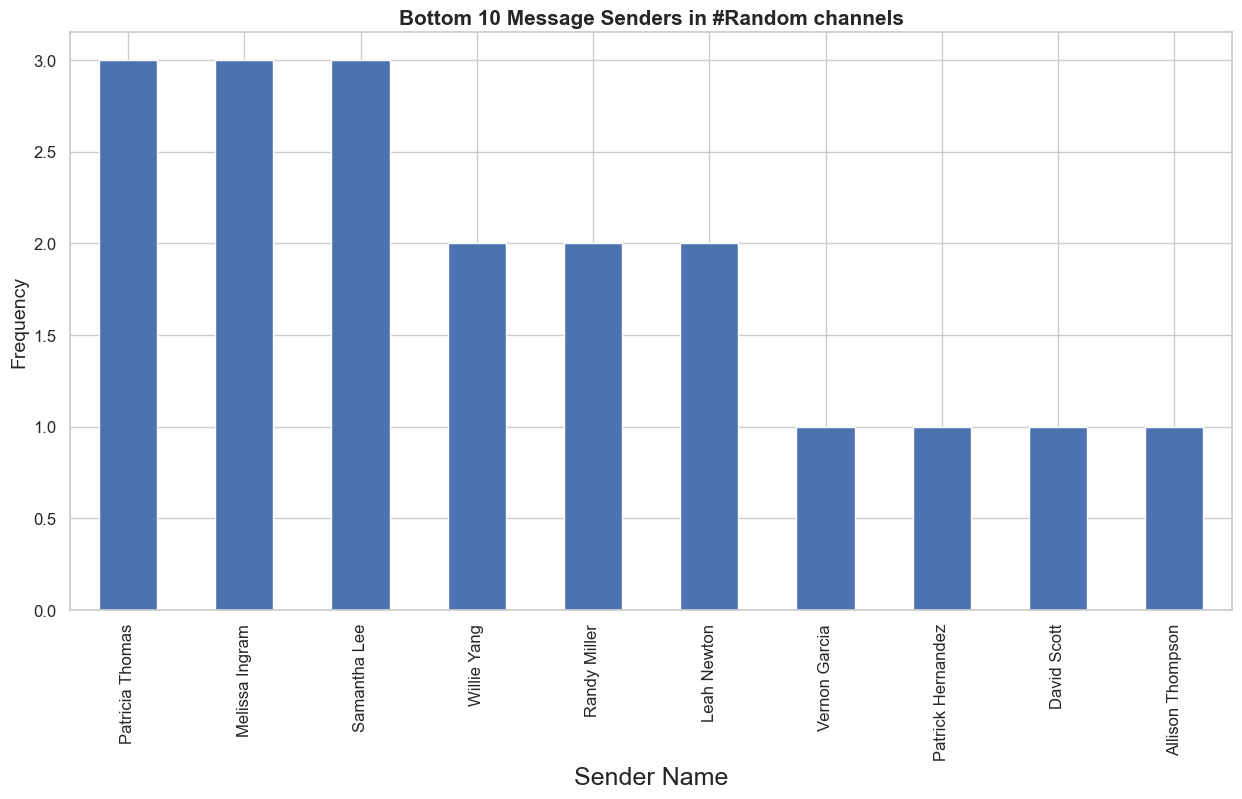

In [91]:
# get the top 20 user in Random channels
get_top_20_user(pfill, 'Random')